In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dist_s1_enumerator import (get_mgrs_tiles_overlapping_geometry, 
                                get_burst_table_from_mgrs_tiles, 
                                get_lut_by_mgrs_tile_ids, 
                                get_rtc_s1_ts_metadata,
                                get_mgrs_burst_lut_path,
                                agg_rtc_metadata_by_burst_id)
from shapely.geometry import Point
from datetime import datetime, timedelta
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
from pathlib import Path

# Provide AOI

In [3]:
# Over Los Padres National Forest, CA
point = Point(-120.0048, 34.8923)
df_aoi = gpd.GeoDataFrame(geometry=[point], crs=CRS.from_epsg(4326))

# Get Overlapping Tiles

Can be point or polygon.

In [4]:
df_mgrs_tiles = get_mgrs_tiles_overlapping_geometry(point)

## Visualize Overlapping Tiles and AOI

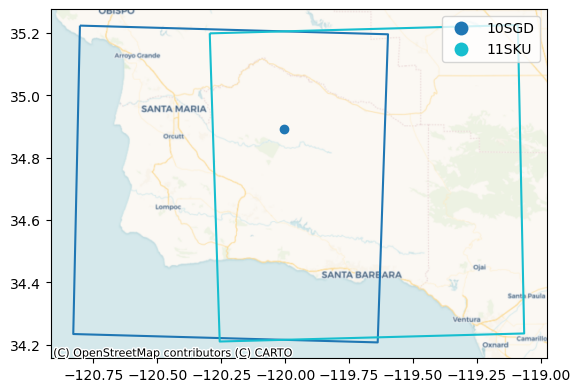

In [5]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.geometry = df_mgrs_tiles_plot.geometry.boundary
df_mgrs_tiles_plot.plot(column='mgrs_tile_id', categorical=True, legend=True, ax=ax)
df_aoi.plot(ax=ax)
ctx.add_basemap(ax,
                crs=df_mgrs_tiles.crs.to_string(),
                source=ctx.providers.CartoDB.Voyager
                )

# Visualize Overlapping Passes

In [6]:
MGRS_TILE = '10SGD'

In [7]:
df_mgrs_burst_luts = get_lut_by_mgrs_tile_ids([MGRS_TILE])
df_mgrs_burst_luts.head()

,mgrs_tile_id,jpl_burst_id,orbit_pass,track_number,acq_group_id_within_mgrs_tile,area_per_acq_group_km2,n_bursts_per_acq_group
0,10SGD,T137-292318-IW1,ASCENDING,137.0,2,17790.460771,15
1,10SGD,T042-088937-IW1,DESCENDING,42.0,1,7291.711452,8
2,10SGD,T144-308026-IW2,DESCENDING,144.0,3,17790.460771,14
3,10SGD,T035-073228-IW3,ASCENDING,35.0,0,7127.138157,7
4,10SGD,T137-292319-IW1,ASCENDING,137.0,2,17790.460771,15


In [8]:
df_bursts = get_burst_table_from_mgrs_tiles([MGRS_TILE])
df_bursts.head()

,jpl_burst_id,geometry,acq_group_id_within_mgrs_tile,mgrs_tile_id
0,T035-073228-IW3,"POLYGON ((-121.08528 34.05287, -120.22744 34.1...",0,10SGD
1,T035-073229-IW3,"POLYGON ((-121.11788 34.21917, -120.25912 34.3...",0,10SGD
2,T035-073230-IW3,"POLYGON ((-121.15285 34.38514, -120.29232 34.5...",0,10SGD
3,T035-073231-IW3,"POLYGON ((-121.18785 34.55111, -120.32556 34.6...",0,10SGD
4,T035-073232-IW3,"POLYGON ((-121.22291 34.71708, -120.35882 34.8...",0,10SGD


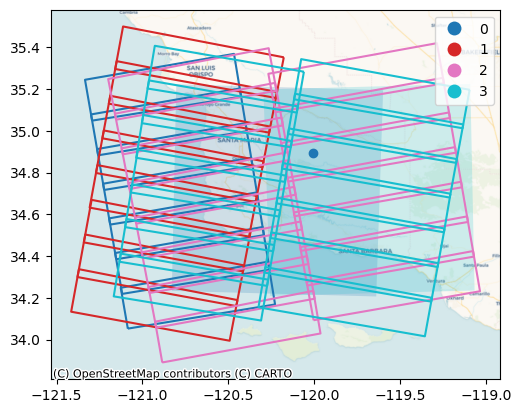

In [9]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.plot(column='mgrs_tile_id', categorical=True, ax=ax, alpha=.2)
df_aoi.plot(ax=ax)
df_bursts_plot = df_bursts.copy()
df_bursts_plot.geometry = df_bursts_plot.geometry.boundary
df_bursts_plot.plot(column='acq_group_id_within_mgrs_tile', categorical=True, ax=ax, legend=True)
ctx.add_basemap(ax,
                crs=df_mgrs_tiles.crs.to_string(),
                source=ctx.providers.CartoDB.Voyager
                )

## Visualize specific group

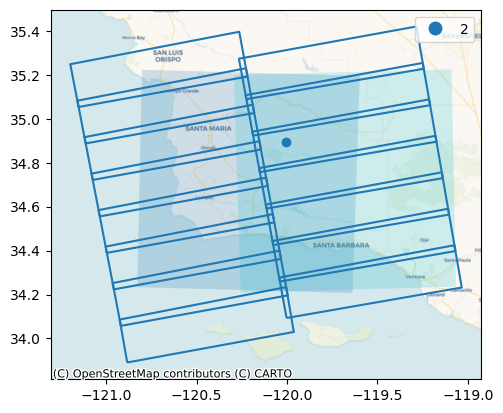

In [10]:
group_id = 2

fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.plot(column='mgrs_tile_id', categorical=True, ax=ax, alpha=.2)
df_aoi.plot(ax=ax)
df_bursts_plot = df_bursts.copy()
df_bursts_plot.geometry = df_bursts_plot.geometry.boundary
df_bursts_plot = df_bursts_plot[df_bursts_plot.acq_group_id_within_mgrs_tile == group_id].reset_index(drop=True)
df_bursts_plot.plot(column='acq_group_id_within_mgrs_tile', categorical=True, ax=ax, legend=True)
ctx.add_basemap(ax,
                crs=df_mgrs_tiles.crs.to_string(),
                source=ctx.providers.CartoDB.Voyager
                )

# Get Latest set of RTC-S1 Data (Post-images)

This could be seen as the post-image set.

In [11]:
df_burst_group = df_bursts[df_bursts.acq_group_id_within_mgrs_tile == group_id].reset_index(drop=True)
burst_ids_group = df_burst_group.jpl_burst_id.tolist()

today = datetime.today()
df_rtc_post = get_rtc_s1_ts_metadata(burst_ids_group, 
                                     latest_acceptable_acq_dt= today, 
                                     earliest_acceptable_acq_dt= today - timedelta(days=30),
                                     maximum_variation_in_acq_dts_seconds=60,
                                     n_images_per_burst = 1)
df_rtc_post.head()

,opera_id,jpl_burst_id,acq_dt,acq_date,polarization,url_vh,url_vv,track_number,geometry
0,OPERA_L2_RTC-S1_T137-292318-IW1_20241103T01590...,T137-292318-IW1,2024-11-03 01:59:02+00:00,2024-11-03,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.88286 33.88932, -119.86999 34.0..."
1,OPERA_L2_RTC-S1_T137-292318-IW2_20241103T01590...,T137-292318-IW2,2024-11-03 01:59:02+00:00,2024-11-03,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.00306 34.08522, -118.95852 34.2..."
2,OPERA_L2_RTC-S1_T137-292319-IW1_20241103T01590...,T137-292319-IW1,2024-11-03 01:59:04+00:00,2024-11-03,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.92164 34.05565, -119.90941 34.2..."
3,OPERA_L2_RTC-S1_T137-292319-IW2_20241103T01590...,T137-292319-IW2,2024-11-03 01:59:05+00:00,2024-11-03,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.04009 34.2519, -118.99323 34.40..."
4,OPERA_L2_RTC-S1_T137-292320-IW1_20241103T01590...,T137-292320-IW1,2024-11-03 01:59:07+00:00,2024-11-03,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.96046 34.22186, -119.94613 34.3..."


In [12]:
assert df_rtc_post.shape[0] <= len(burst_ids_group)
df_rtc_post.shape[0], len(burst_ids_group)

(15, 15)

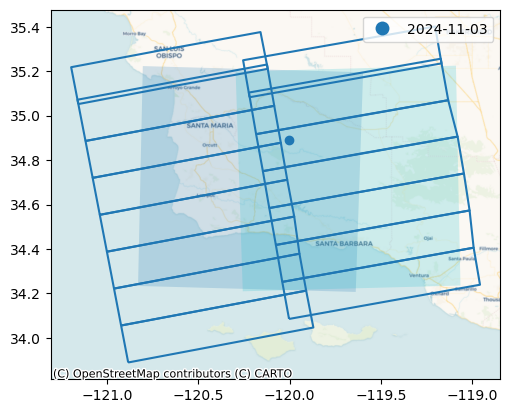

In [13]:
group_id = 2

fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.plot(column='mgrs_tile_id', categorical=True, ax=ax, alpha=.2)
df_aoi.plot(ax=ax)
df_rtc_plot = df_rtc_post.copy()
df_rtc_plot.geometry = df_rtc_plot.geometry.boundary
df_rtc_plot.plot(column='acq_date', categorical=True, ax=ax, legend=True)
ctx.add_basemap(ax,
                crs=df_mgrs_tiles.crs.to_string(),
                source=ctx.providers.CartoDB.Voyager
                )

## Few minor notes
1. The geometries from our burst table differ from those collected from the DAAC (note the overlap)
2. In some cases, the burst ids collected from the latest pass will equal the total fixed bursts requests. In some cases, the actual data from the latest pass will be *less* than the requested bursts. This is due to S1 availability.

# Get historical baseline (Pre-images)

In [14]:
post_dt = df_rtc_post.acq_dt.min()
post_dt

Timestamp('2024-11-03 01:59:02+0000', tz='UTC')

In [15]:
df_rtc_pre = get_rtc_s1_ts_metadata(burst_ids_group, 
                                     latest_acceptable_acq_dt= post_dt - timedelta(days=1), 
                                     earliest_acceptable_acq_dt= post_dt - timedelta(days=366),
                                     n_images_per_burst = 10)

In [16]:
df_rtc_pre.head()

,opera_id,jpl_burst_id,acq_dt,acq_date,polarization,url_vh,url_vv,track_number,geometry
0,OPERA_L2_RTC-S1_T137-292318-IW1_20240706T01590...,T137-292318-IW1,2024-07-06 01:59:01+00:00,2024-07-06,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.87989 33.88858, -119.86699 34.0..."
1,OPERA_L2_RTC-S1_T137-292318-IW1_20240718T01590...,T137-292318-IW1,2024-07-18 01:59:00+00:00,2024-07-18,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.88027 33.88844, -119.86739 34.0..."
2,OPERA_L2_RTC-S1_T137-292318-IW1_20240730T01590...,T137-292318-IW1,2024-07-30 01:59:00+00:00,2024-07-30,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.88131 33.88936, -119.86846 34.0..."
3,OPERA_L2_RTC-S1_T137-292318-IW1_20240811T01590...,T137-292318-IW1,2024-08-11 01:59:00+00:00,2024-08-11,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.88224 33.88919, -119.86935 34.0..."
4,OPERA_L2_RTC-S1_T137-292318-IW1_20240823T01590...,T137-292318-IW1,2024-08-23 01:59:00+00:00,2024-08-23,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.88231 33.88907, -119.86942 34.0..."


In [17]:
df_rtc_pre_agg = agg_rtc_metadata_by_burst_id(df_rtc_pre)
df_rtc_pre_agg.head()

,jpl_burst_id,count,earliest_acq_date,latest_acq_date
0,T137-292318-IW1,10,2024-07-06,2024-10-22
1,T137-292318-IW2,10,2024-07-06,2024-10-22
2,T137-292319-IW1,10,2024-07-06,2024-10-22
3,T137-292319-IW2,10,2024-07-06,2024-10-22
4,T137-292320-IW1,10,2024-07-06,2024-10-22


# Localizing Inputs

In [43]:
from dist_s1_enumerator.rtc_s1_io import localize_rtc_s1_ts, generate_rtc_s1_local_paths

In [53]:
mgrs_dir = Path('out')/ MGRS_TILE
mgrs_dir.mkdir(exist_ok=True, parents=True)

In [55]:
df_rtc_pre_loc = localize_rtc_s1_ts(df_rtc_pre, mgrs_dir, max_workers=5)

100%|█| 300/300 [00:00<00:00, 36340.54i


In [56]:
df_rtc_post_loc = localize_rtc_s1_ts(df_rtc_post, mgrs_dir, max_workers=5)

100%|█| 30/30 [00:00<00:00, 348557.12it


In [57]:
df_rtc_post_loc.head()

,opera_id,jpl_burst_id,acq_dt,acq_date,polarization,url_vh,url_vv,track_number,geometry,loc_path_vv,loc_path_vh
0,OPERA_L2_RTC-S1_T137-292318-IW1_20241103T01590...,T137-292318-IW1,2024-11-03 01:59:02+00:00,2024-11-03,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.88286 33.88932, -119.86999 34.0...",out/10SGD/137/2024-11-03/OPERA_L2_RTC-S1_T137-...,out/10SGD/137/2024-11-03/OPERA_L2_RTC-S1_T137-...
1,OPERA_L2_RTC-S1_T137-292318-IW2_20241103T01590...,T137-292318-IW2,2024-11-03 01:59:02+00:00,2024-11-03,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.00306 34.08522, -118.95852 34.2...",out/10SGD/137/2024-11-03/OPERA_L2_RTC-S1_T137-...,out/10SGD/137/2024-11-03/OPERA_L2_RTC-S1_T137-...
2,OPERA_L2_RTC-S1_T137-292319-IW1_20241103T01590...,T137-292319-IW1,2024-11-03 01:59:04+00:00,2024-11-03,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.92164 34.05565, -119.90941 34.2...",out/10SGD/137/2024-11-03/OPERA_L2_RTC-S1_T137-...,out/10SGD/137/2024-11-03/OPERA_L2_RTC-S1_T137-...
3,OPERA_L2_RTC-S1_T137-292319-IW2_20241103T01590...,T137-292319-IW2,2024-11-03 01:59:05+00:00,2024-11-03,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.04009 34.2519, -118.99323 34.40...",out/10SGD/137/2024-11-03/OPERA_L2_RTC-S1_T137-...,out/10SGD/137/2024-11-03/OPERA_L2_RTC-S1_T137-...
4,OPERA_L2_RTC-S1_T137-292320-IW1_20241103T01590...,T137-292320-IW1,2024-11-03 01:59:07+00:00,2024-11-03,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,137,"POLYGON ((-120.96046 34.22186, -119.94613 34.3...",out/10SGD/137/2024-11-03/OPERA_L2_RTC-S1_T137-...,out/10SGD/137/2024-11-03/OPERA_L2_RTC-S1_T137-...


In [60]:
df_rtc_pre_loc.to_parquet(f'{MGRS_TILE}_pre.parquet')
df_rtc_post_loc.to_parquet(f'{MGRS_TILE}_post.parquet')